In [108]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from matplotlib import pyplot as plt
from PIL import Image
import glob
import numpy as np
import scipy.ndimage as nd
import itertools
import sys
sys.path.append('..')
import plot_helper as plt_hp
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
import lpips

In [109]:
device = torch.device('cuda:0')
kwargs_alex_finetuned={'net': 'alex', 
        'pretrained': True,
        'model_path': '/NS/twitter_archive2/work/vnanda/PerceptualSimilarity/lpips/weights/v0.1/alex.pth'}
kwargs_vgg_finetuned={'net': 'vgg16', 
        'pretrained': True,
        'model_path': '/NS/twitter_archive2/work/vnanda/PerceptualSimilarity/lpips/weights/v0.1/vgg.pth'}
kwargs_vgg_imagenet={'net': 'vgg16', 
        'pretrained': False}
kwargs_alex_imagenet={'net': 'vgg16', 
        'pretrained': False}
L_objs = [lpips.LPIPS(**kwargs_alex_finetuned).to(device), 
          lpips.LPIPS(**kwargs_alex_imagenet).to(device), 
          lpips.LPIPS(**kwargs_vgg_finetuned).to(device), 
          lpips.LPIPS(**kwargs_vgg_imagenet).to(device)
         ]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /NS/twitter_archive2/work/vnanda/PerceptualSimilarity/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg16], v[0.1], spatial [off]
Setting up [LPIPS] perceptual loss: trunk [vgg16], v[0.1], spatial [off]
Loading model from: /NS/twitter_archive2/work/vnanda/PerceptualSimilarity/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg16], v[0.1], spatial [off]


In [110]:
# model_arch = 'densenet121'
# model_arch = 'inceptionv3'
# model_arch = 'vgg16'
model_arch = 'resnet18'
target_image_dataset = 'cifar10'
training_dataset = 'cifar10'

# model_arch = 'resnet18'
# model_arch = 'resnet50'
# model_arch = 'vgg16_bn'
# target_image_dataset = 'imagenet'
# training_dataset = 'imagenet'

# append = 'nonrob'
# append = 'rob_l2eps3'

# append = 'nonrob_rand_seed_2'
# append = 'robl2eps1_rand_seed_2'
# append = 'rob_l2eps1'
# append = 'nonrob_simclraug'
# append = 'simclr_all'
# append = 'simclr_nocolor'
append = 'simclr_adv'


seed = 'super-noise'
# seed = 'light-noise'

reg_free = 'reg_free'
human_loss = 'reg_free_transforms_True'
# human_loss = 'reg_free_transforms_True_fft'
# human_loss = 'freq_transforms_True_fft'
# human_loss = 'freq'
# adv_loss = 'adv_alex_finetuned'
adv_loss = 'adv_alex_imagenet' ## use for cifar10

# inversion_losses = ['reg_free', 'freq']
# transform_robustness = [True, False]
# ffts = [True, False]
# additional_losses = ['adv_alex_finetuned', 'adv_alex_finetuned_seed', 
#                      'adv_alex_imagenet', 'adv_alex_imagenet_seed']

In [111]:
# for loss in [reg_free, human_loss, adv_loss]:
for loss in [adv_loss]:
    inverted_images_dir = f'./results/generated_images/{training_dataset}/'\
        f'{target_image_dataset}_{model_arch}_{loss}_{append}'
    
#     seeds = imageio.imread(f'{inverted_images_dir}/{seed}.png')
    seeds = np.array(Image.open(f'{inverted_images_dir}/{seed}.png'))
    targets, results = None, None
    seeds = torch.tensor(np.moveaxis(seeds/255., -1, 0)).to(device)
    for result_fpath in glob.glob(f'{inverted_images_dir}/result/*_seed_{seed}.png'):
        filename = result_fpath.split('/')[-1]
        target_fpath = f'{inverted_images_dir}/target/{filename}'
#         target, result = np.moveaxis(imageio.imread(target_fpath)/255., -1, 0), \
#             np.moveaxis(imageio.imread(result_fpath)/255., -1, 0)
        target, result = np.moveaxis(np.array(Image.open(target_fpath))/255., -1, 0), \
            np.moveaxis(np.array(Image.open(result_fpath))/255., -1, 0)
        target, result = torch.tensor(target).to(device).unsqueeze(0), \
            torch.tensor(result).to(device).unsqueeze(0)
        targets = target if targets is None else torch.cat((targets, target))
        results = result if results is None else torch.cat((results, result))
    seeds = torch.ones((len(targets), *seeds.shape), device=device) * \
        seeds.unsqueeze(0)
    
    print (loss)
    alignments = []
    for L in L_objs:
        d_res_seed = L(results.float(), seeds.float(), normalize=True).squeeze()
        d_res_target = L(results.float(), targets.float(), normalize=True).squeeze()    
        alignments.append(100 * torch.sum(d_res_target <= d_res_seed).item()/len(results))
    print (alignments)
    if loss == adv_loss:
        print (f'Alignment: ${np.mean(alignments[1:2]):.2f}_{{\pm {np.std(alignments[1:2]):.2f}}}$')
    else:
        print (f'Alignment: ${np.mean(alignments):.2f}_{{\pm {np.std(alignments):.2f}}}$')
    print ()
    d_res_target, d_res_seed, targets, results, seeds = None, None, None, None, None
    torch.cuda.empty_cache()

adv_alex_imagenet
[43.0, 2.0, 0.0, 0.0]
Alignment: $2.00_{\pm 0.00}$



In [103]:
def measure_alignment(target_dataset, source_dataset, architectures, appends):
    alignments_mean, alignments_std = [], []
    for a in appends:
        means, stds = [], []
        for arch in architectures:
            inverted_images_dir = f'./results/generated_images/{source_dataset}/{target_dataset}_{arch}_{a}'
            
            if not os.path.exists(f'{inverted_images_dir}/{seed}.png'):
                means.append(np.nan)
                stds.append(np.nan)
                continue

            seeds = np.array(Image.open(f'{inverted_images_dir}/{seed}.png'))
            targets, results = None, None
            seeds = torch.tensor(np.moveaxis(seeds/255., -1, 0)).to(device)
            for result_fpath in glob.glob(f'{inverted_images_dir}/result/*_seed_{seed}.png'):
                filename = result_fpath.split('/')[-1]
                target_fpath = f'{inverted_images_dir}/target/{filename}'
                target, result = np.moveaxis(np.array(Image.open(target_fpath))/255., -1, 0), \
                    np.moveaxis(np.array(Image.open(result_fpath))/255., -1, 0)
                target, result = torch.tensor(target).to(device).unsqueeze(0), \
                    torch.tensor(result).to(device).unsqueeze(0)
                targets = target if targets is None else torch.cat((targets, target))
                results = result if results is None else torch.cat((results, result))
            seeds = torch.ones((len(targets), *seeds.shape), device=device) * seeds.unsqueeze(0)

            alignments = []
            for L in L_objs:
                d_res_seed = L(results.float(), seeds.float(), normalize=True).squeeze()
                d_res_target = L(results.float(), targets.float(), normalize=True).squeeze()    
                alignments.append(100 * torch.sum(d_res_target <= d_res_seed).item()/len(results))

            means.append(np.mean(alignments))
            stds.append(np.std(alignments))

        alignments_mean.append(means)
        alignments_std.append(stds)
    return alignments_mean, alignments_std

## Model Architecture and Loss Functions

In [97]:
# target_dataset = 'cifar10'
# source_dataset = 'cifar10'
# architectures = ['resnet18', 'densenet121', 'vgg16', 'inceptionv3']
# appends = ['reg_free_nonrob_rand_seed_2', 
#            'reg_free_robl2eps1_rand_seed_2',
#            'reg_free_tradesbeta0.1eps1',
#            'reg_free_tradesbeta1eps1',
#            'reg_free_tradesbeta6eps1',
#            'reg_free_tradesbeta10eps1',
#            'reg_free_martbeta0.1eps1',
#            'reg_free_martbeta1eps1',
#            'reg_free_martbeta6eps1',
#            'reg_free_martbeta10eps1']
# legend_vals = ['Standard', 'AT', 
#                'TRADES (0.1)', 'TRADES (1)', 
#                'TRADES (6)', 'TRADES (10)', 
#                'MART (0.1)', 'MART (1)', 
#                'MART (6)', 'MART (10)']

# target_dataset = 'imagenet'
# source_dataset = 'imagenet'
# architectures = ['resnet18', 'resnet50', 'vgg16_bn']
# appends = ['reg_free_nonrob', 
#            'reg_free_rob_l2eps3']
# legend_vals = ['Standard', 'AT']

target_dataset = 'cifar100'
source_dataset = 'cifar100'
architectures = ['resnet18', 'densenet121', 'vgg16', 'inceptionv3']
appends = ['reg_free_nonrob', 
           'reg_free_rob_l2eps1']
legend_vals = ['Standard', 'AT']


markers = ['s','^',] + ['o'] * (len(appends) - 2)

In [98]:
alignments_mean, alignments_std = \
    measure_alignment(target_dataset, source_dataset, architectures, appends)

In [62]:
import importlib
importlib.reload(plt_hp)

<module 'plot_helper' from '../plot_helper.py'>

../plot_helper.py:674: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  fmt=markers[idx] if markers is not None else 'o')
../plot_helper.py:674: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "^" (-> marker='^'). The keyword argument will take precedence.
  fmt=markers[idx] if markers is not None else 'o')


'results/cifar100/alignment_due_to_loss_and_archs/cifar100_alignment_robust_vs_nonrobust_scatter.pdf'

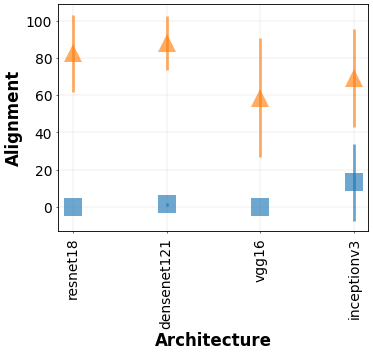

<Figure size 150x150 with 0 Axes>

In [99]:
x_vals = [np.arange(len(architectures))] * len(alignments_mean)
plt_hp.scatter_plot(x_vals, alignments_mean, 
                    labels=None, plot_title='', subfolder='alignment_due_to_loss_and_archs', 
                    filename=f'{target_dataset}_alignment_robust_vs_nonrobust_scatter', 
                    x_label='Architecture', y_label='Alignment', extension='pdf', figsize=(8,6), 
                    x_ticklabels=architectures, x_err=None, y_err=alignments_std, 
                    legend_vals=legend_vals, paper_friendly_plots=True, 
                    markers=markers, sizes=[25,25] + [20] * (len(x_vals) - 2), 
                    results_subfolder_name=source_dataset,
                    legend_ncol=3)

## Data Augmentation

In [92]:
target_dataset = 'cifar10'
source_dataset = 'cifar10'
architectures = ['resnet18', 'densenet121', 'vgg16', 'inceptionv3']

nonrob_appends = ['reg_free_nonrob_rand_seed_2', 'reg_free_nonrob_simclraug']
rob_appends = ['reg_free_robl2eps1_rand_seed_2', 'reg_free_rob_noaug']


alignments_mean_nonrob, alignments_std_nonrob = measure_alignment(target_dataset, source_dataset, 
                                                    architectures, nonrob_appends)
alignments_mean_rob, alignments_std_rob = measure_alignment(target_dataset, source_dataset, 
                                                    architectures, rob_appends)

In [36]:
for a, means, stds in zip(nonrob_appends, alignments_mean_nonrob, alignments_std_nonrob):
    for arch, m, s in zip(architectures, means, stds):
        print (f'{a}, {arch}, ${m:.2f}_{{\pm {s:.2f}}}$')
print ()
print ()
for a, means, stds in zip(rob_appends, alignments_mean_rob, alignments_std_rob):
    for arch, m, s in zip(architectures, means, stds):
        print (f'{a}, {arch}, ${m:.2f}_{{\pm {s:.2f}}}$')

reg_free_nonrob_rand_seed_2, resnet18, $0.00_{\pm 0.00}$
reg_free_nonrob_rand_seed_2, densenet121, $0.00_{\pm 0.00}$
reg_free_nonrob_rand_seed_2, vgg16, $0.00_{\pm 0.00}$
reg_free_nonrob_rand_seed_2, inceptionv3, $0.00_{\pm 0.00}$
reg_free_nonrob_simclraug, resnet18, $0.00_{\pm 0.00}$
reg_free_nonrob_simclraug, densenet121, $1.00_{\pm 1.73}$
reg_free_nonrob_simclraug, vgg16, $0.00_{\pm 0.00}$
reg_free_nonrob_simclraug, inceptionv3, $0.00_{\pm 0.00}$


reg_free_robl2eps1_rand_seed_2, resnet18, $76.50_{\pm 15.91}$
reg_free_robl2eps1_rand_seed_2, densenet121, $93.50_{\pm 9.60}$
reg_free_robl2eps1_rand_seed_2, vgg16, $0.25_{\pm 0.43}$
reg_free_robl2eps1_rand_seed_2, inceptionv3, $24.25_{\pm 25.17}$
reg_free_rob_noaug, resnet18, $30.00_{\pm 12.02}$
reg_free_rob_noaug, densenet121, $93.75_{\pm 8.20}$
reg_free_rob_noaug, vgg16, $1.00_{\pm 1.73}$
reg_free_rob_noaug, inceptionv3, $12.25_{\pm 20.08}$


In [100]:
# target_dataset = 'imagenet'
# source_dataset = 'imagenet'
# architectures = ['resnet18', 'resnet50']

# rob_appends = ['reg_free_freerob_linf', 'reg_free_freerob_linf_noaug']


target_dataset = 'cifar100'
source_dataset = 'cifar100'
architectures = ['resnet18', 'vgg16', 'densenet121', 'inceptionv3']

rob_appends = ['reg_free_rob_l2eps1', 'reg_free_rob_l2eps1_noaug']


alignments_mean_rob, alignments_std_rob = measure_alignment(target_dataset, source_dataset, 
                                                    architectures, rob_appends)

In [101]:
for a, means, stds in zip(rob_appends, alignments_mean_rob, alignments_std_rob):
    for arch, m, s in zip(architectures, means, stds):
        print (f'{a}, {arch}, ${m:.2f}_{{\pm {s:.2f}}}$')

reg_free_rob_l2eps1, resnet18, $82.50_{\pm 20.85}$
reg_free_rob_l2eps1, vgg16, $58.75_{\pm 32.15}$
reg_free_rob_l2eps1, densenet121, $88.00_{\pm 14.51}$
reg_free_rob_l2eps1, inceptionv3, $69.25_{\pm 26.39}$
reg_free_rob_l2eps1_noaug, resnet18, $81.50_{\pm 15.58}$
reg_free_rob_l2eps1_noaug, vgg16, $46.25_{\pm 32.25}$
reg_free_rob_l2eps1_noaug, densenet121, $89.75_{\pm 15.01}$
reg_free_rob_l2eps1_noaug, inceptionv3, $84.75_{\pm 13.70}$


## SimCLR

In [112]:
# target_dataset = 'cifar10'
# source_dataset = 'cifar10'
target_dataset = 'cifar100'
source_dataset = 'cifar100'
architectures = ['resnet18']

epochs = range(49, 1000, 50)

appends_all = [f'reg_free_simclr_all_{e}' for e in epochs]
appends_nocolor = [f'reg_free_simclr_nocolor_{e}' for e in epochs]
appends_adv = [f'reg_free_simclr_adv_{e}' for e in epochs]

# appends_sup_rob = ['reg_free_robl2eps1_rand_seed_2']
appends_sup_rob = ['reg_free_rob_l2eps1']

alignments_mean_all, alignments_std_all = measure_alignment(target_dataset, source_dataset, 
                                                    architectures, appends_all)
alignments_mean_nocolor, alignments_std_nocolor = measure_alignment(target_dataset, source_dataset, 
                                                    architectures, appends_nocolor)
alignments_mean_adv, alignments_std_adv = measure_alignment(target_dataset, source_dataset, 
                                                    architectures, appends_adv)
alignments_mean_sup, alignments_std_sup = measure_alignment(target_dataset, source_dataset, 
                                                    architectures, appends_sup_rob)

In [113]:
alignments_mean_adv, alignments_std_adv = \
    np.array(alignments_mean_adv).squeeze(), np.array(alignments_std_adv).squeeze()
alignments_mean_nocolor, alignments_std_nocolor = \
    np.array(alignments_mean_nocolor).squeeze(), np.array(alignments_std_nocolor).squeeze()
alignments_mean_all, alignments_std_all = \
    np.array(alignments_mean_all).squeeze(), np.array(alignments_std_all).squeeze()
alignments_mean_sup, alignments_std_sup = np.array(alignments_mean_sup).squeeze(), \
    np.array(alignments_std_sup).squeeze()

In [114]:
alignments_mean_sup, alignments_std_sup

(array(85.25), array(14.75423668))

../plot_helper.py:102: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")
../plot_helper.py:102: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")
../plot_helper.py:102: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


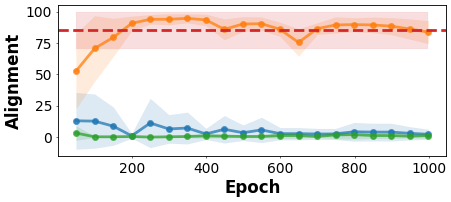

'results/cifar100/alignment_due_to_training_paradigm/cifar100_resnet18_simclr.pdf'

In [115]:
plt_hp.line_plot([alignments_mean_all, alignments_mean_adv, alignments_mean_nocolor], 
                 'Epoch', 'Alignment', '', 'alignment_due_to_training_paradigm', 
                 f'{target_dataset}_{architectures[0]}_simclr', extension='png', 
                 x_vals=list(epochs), vertical_line=None, 
                 legend_vals=['SimCLR DA', 'SimCLR (DA + Adv)', 
                              'SimCLR (DA - color)', 'Supervised AT\n(best model)'], 
                 horizontal_lines=[float(alignments_mean_sup)], 
                 horizontal_lines_err=[float(alignments_std_sup)], 
                 colors=None, linestyles=['-', '-', '-', '--'],legend_ncol=2,
                 y_lims=None, root_dir='.', paper_friendly_plots=True, plot_inside=False, 
                 legend_location='best', savefig=True, figsize=(10,4), 
                 marker=['o', 'o', 'o', 'o'], results_subfolder_name=source_dataset, 
                 grid_spacing=None, y_err=[alignments_std_all, alignments_std_adv, alignments_std_nocolor])